# Proyek Klasifikasi Gambar: Data Historis BMRI (Saham)
- **Nama:** Yoan Rifqi Candra
- **Email:** yoanrifqicandra@gmail.com
- **ID Dicoding:** Yoan Rifqi Candra

## Business Understanding

### Latar Belakang

Bank Mandiri (BMRI) merupakan salah satu bank terbesar di Indonesia yang terdaftar di Bursa Efek Indonesia (BEI). Pergerakan harga saham BMRI menjadi perhatian banyak investor dan analis pasar karena mencerminkan kondisi keuangan perusahaan serta sentimen pasar terhadap sektor perbankan nasional.

#### Permasalahan Bisnis
- Mengidentifikasi tren harga saham BMRI dari waktu ke waktu
- Menentukan waktu yang tepat untuk membeli atau menjual saham
- Memprediksi pergerakan harga saham berdasarkan data historis
- Memahami pengaruh volumen transaksi terhadap volatilitas saham

#### Tujuan Bisnis
- Menyediakan wawasan tentang tren historis saham BMRI
- Membantu pengambilan keputusan investasi jangka pendek maupun jangka panjang
- Mengidentifikasi pola atau anomali yang signifikan dalam data historis
- Memberikan dasar untuk pengembangan modal prediktif harga saham
- Memprediksi harga saham untuk waktu kedepan

#### Tujuan Analisis
- Menyajikan visualisasi pergerakan harga saham BMRI dalam periode tertentu (harian/minggu/bulanan)
- Menghitung indikator teknikal seperti Moving Average, RSI, Bollinger Bands, dll
- Melakukan segmentasi waktu berdasarkan tren (bullish, bearish, sideways)
- Melakukan korelasi antara volume dan harga untuk mengukur sentimen pasar
- Memprediksi harga saham untuk mengidentifikasi peluang di masa depan

#### Manfaat
- Memberikan insight bagi investor untuk strategi entry dan exit
- Mendukung pengambilan keputusan berbasis data historis
- Menjadi dasar untuk strategi manajemen risiko

## Data Understanding

In [1]:
# Import library
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime as dt
from prophet import Prophet

import statsmodels.api as sm
from scipy import stats
from plotly import tools
from chart_studio.plotly import plot, iplot
import plotly.figure_factory as ff
import chart_studio.tools as tls
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

#Modeling
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import matplotlib.dates as mdates
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

#Evaluation
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

c:\Users\Yoan Rifqi\Downloads\Project Analysis Personal\Predictive Analysis Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
data = pd.read_csv("Data Historis BMRI.csv")
data

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,16/04/2025,4.670,4.730,4.740,4.670,"64,70M","-0,85%"
1,15/04/2025,4.710,4.800,4.820,4.710,"231,01M","-0,84%"
2,14/04/2025,4.750,4.650,4.750,4.650,"423,72M","-6,86%"
3,11/04/2025,5.100,5.000,5.175,4.950,"384,96M","1,49%"
4,10/04/2025,5.025,5.200,5.225,4.970,"559,97M","6,69%"
...,...,...,...,...,...,...,...
1019,22/01/2021,7.200,7.275,7.350,7.125,"58,68M","-0,69%"
1020,21/01/2021,7.250,7.375,7.375,7.200,"41,03M","-1,69%"
1021,20/01/2021,7.375,7.000,7.450,7.000,"110,47M","5,73%"
1022,19/01/2021,6.975,7.000,7.025,6.850,"38,92M","0,72%"


In [3]:
# rename columns for easier access
data.rename(columns={'Tanggal': 'Date', 
                     'Terakhir': 'Close',
                     'Pembukaan' : 'Open',
                     'Tertinggi' : 'High',
                     'Terendah' : 'Low',
                     'Vol' : 'Volume',
                     'Perubahan%' : 'Change(%)'}, inplace=True)

data

,Date,Close,Open,High,Low,Vol.,Change(%)
0,16/04/2025,4.670,4.730,4.740,4.670,"64,70M","-0,85%"
1,15/04/2025,4.710,4.800,4.820,4.710,"231,01M","-0,84%"
2,14/04/2025,4.750,4.650,4.750,4.650,"423,72M","-6,86%"
3,11/04/2025,5.100,5.000,5.175,4.950,"384,96M","1,49%"
4,10/04/2025,5.025,5.200,5.225,4.970,"559,97M","6,69%"
...,...,...,...,...,...,...,...
1019,22/01/2021,7.200,7.275,7.350,7.125,"58,68M","-0,69%"
1020,21/01/2021,7.250,7.375,7.375,7.200,"41,03M","-1,69%"
1021,20/01/2021,7.375,7.000,7.450,7.000,"110,47M","5,73%"
1022,19/01/2021,6.975,7.000,7.025,6.850,"38,92M","0,72%"


In [4]:
# replace 'M' for volume column and convert to float
def clean_volume_column(df, column_name):
    df[column_name] = df[column_name].str.replace('M', '', regex=False).str.replace(',', '.', regex=False).astype(float)
    return df

data = clean_volume_column(data, 'Vol.')
data

,Date,Close,Open,High,Low,Vol.,Change(%)
0,16/04/2025,4.670,4.730,4.740,4.670,64.70,"-0,85%"
1,15/04/2025,4.710,4.800,4.820,4.710,231.01,"-0,84%"
2,14/04/2025,4.750,4.650,4.750,4.650,423.72,"-6,86%"
3,11/04/2025,5.100,5.000,5.175,4.950,384.96,"1,49%"
4,10/04/2025,5.025,5.200,5.225,4.970,559.97,"6,69%"
...,...,...,...,...,...,...,...
1019,22/01/2021,7.200,7.275,7.350,7.125,58.68,"-0,69%"
1020,21/01/2021,7.250,7.375,7.375,7.200,41.03,"-1,69%"
1021,20/01/2021,7.375,7.000,7.450,7.000,110.47,"5,73%"
1022,19/01/2021,6.975,7.000,7.025,6.850,38.92,"0,72%"


In [5]:
# replace "%" for Change(%) column and convert to float
def clean_change_column(df, column_name):
    df[column_name] = df[column_name].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)
    return df

data = clean_change_column(data, 'Change(%)')
data

,Date,Close,Open,High,Low,Vol.,Change(%)
0,16/04/2025,4.670,4.730,4.740,4.670,64.70,-0.85
1,15/04/2025,4.710,4.800,4.820,4.710,231.01,-0.84
2,14/04/2025,4.750,4.650,4.750,4.650,423.72,-6.86
3,11/04/2025,5.100,5.000,5.175,4.950,384.96,1.49
4,10/04/2025,5.025,5.200,5.225,4.970,559.97,6.69
...,...,...,...,...,...,...,...
1019,22/01/2021,7.200,7.275,7.350,7.125,58.68,-0.69
1020,21/01/2021,7.250,7.375,7.375,7.200,41.03,-1.69
1021,20/01/2021,7.375,7.000,7.450,7.000,110.47,5.73
1022,19/01/2021,6.975,7.000,7.025,6.850,38.92,0.72


In [6]:
data['Kode'] = 'BMRI'

In [7]:
# missing values
data.isnull().sum()

Date         0
Close        0
Open         0
High         0
Low          0
Vol.         0
Change(%)    0
Kode         0
dtype: int64

In [8]:
# convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

In [9]:
# data types
data.dtypes

Date         datetime64[ns]
Close               float64
Open                float64
High                float64
Low                 float64
Vol.                float64
Change(%)           float64
Kode                 object
dtype: object

In [10]:
# data duplicates
data.duplicated().sum()

np.int64(0)

In [11]:
# information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1024 non-null   datetime64[ns]
 1   Close      1024 non-null   float64       
 2   Open       1024 non-null   float64       
 3   High       1024 non-null   float64       
 4   Low        1024 non-null   float64       
 5   Vol.       1024 non-null   float64       
 6   Change(%)  1024 non-null   float64       
 7   Kode       1024 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 64.1+ KB


In [12]:
# description of the dataset
data.describe()

,Date,Close,Open,High,Low,Vol.,Change(%)
count,1024,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000
mean,2023-02-22 08:05:09.375000064,5.026965,5.030024,5.089081,4.967398,104.926650,0.001279
min,2021-01-18 00:00:00,2.825000,2.825000,2.875000,2.800000,7.070000,-50.000000
25%,2022-01-27 18:00:00,3.838000,3.850000,3.875000,3.813000,63.185000,-0.970000
50%,2023-02-11 12:00:00,5.081500,5.075000,5.125000,5.025000,88.115000,0.000000
75%,2024-03-09 06:00:00,6.075000,6.075000,6.150000,6.025000,124.472500,1.050000
max,2025-04-16 00:00:00,7.450000,7.450000,7.550000,7.400000,738.450000,8.810000
std,NaN,1.313988,1.314307,1.330760,1.297806,70.961525,2.459295


## Data Preparation

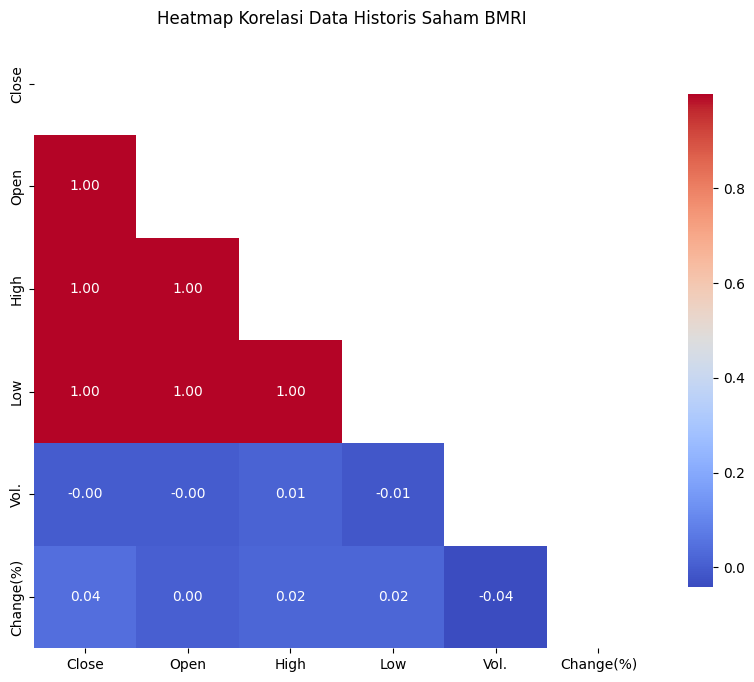

In [14]:
# Hitung korelasi hanya pada kolom numerik
corr_matrix = data.select_dtypes(include=[np.number]).corr()

# Buat mask segitiga atas
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Heatmap Korelasi Data Historis Saham BMRI')
plt.show()

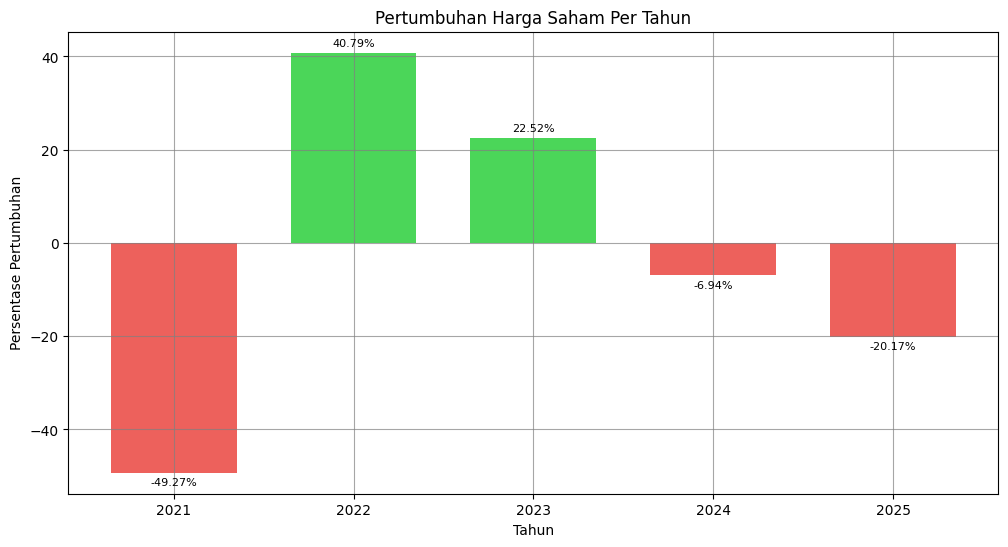

In [15]:
# Make sure the 'Date' column is of type datetime
data['Date'] = pd.to_datetime(data['Date'])

# Unique year list
tahun_list = sorted(data['Date'].dt.year.unique())

# List to store growth per year
pertumbuhan_per_tahun = []

# Loop to calculate growth per year
for tahun in tahun_list:
    data_tahun = data[data['Date'].dt.year == tahun]
    if not data_tahun.empty:
        harga_awal = data_tahun[data_tahun['Date'] == data_tahun['Date'].min()]['Close'].values.item()
        harga_akhir = data_tahun[data_tahun['Date'] == data_tahun['Date'].max()]['Close'].values.item()
        growth = ((harga_akhir - harga_awal) / harga_awal) * 100
        pertumbuhan_per_tahun.append(growth)

# Specify the color of the bar based on growth (green if positive, red if negative)
warna_bars = ['#4bd659' if growth >= 0 else '#ed615c' for growth in pertumbuhan_per_tahun]

# Visualization of growth per year
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(tahun_list, pertumbuhan_per_tahun, color=warna_bars, width=0.7)

# Annotate the percentage on each bar
for i, v in enumerate(pertumbuhan_per_tahun):
    # Ensure the label is in the right position above or below the bar
    ax.text(tahun_list[i], v + (1 if v >= 0 else -1), f'{round(v, 2)}%', ha='center', va='bottom' if v >= 0 else 'top', color='black', fontsize=8)

# Axis label
ax.set_xlabel('Tahun')
ax.set_ylabel('Persentase Pertumbuhan')
ax.set_title('Pertumbuhan Harga Saham Per Tahun')

# Adding a grid
ax.grid(True, linestyle='-', color='gray', alpha=0.7)

# show the plot
#plt.xticks(rotation=45)
plt.show()


In [16]:
# create a line chart
fig = px.line(data, x='Date', y='Close', 
              title='Grafik Pergerakan Harga Saham BMRI', 
              labels={'Close': 'Harga Saham', 'Date' : 'Tahun'}, 
              line_shape='linear', 
              template='plotly_dark')

# Set the x-axis format to display only the year
fig.update_xaxes(tickformat="%Y", gridcolor='gray', gridwidth=1, zerolinecolor='gray', zerolinewidth=1)
fig.update_yaxes(title_text='Harga Saham', gridcolor='gray', gridwidth=1, zerolinecolor='gray', zerolinewidth=1)

# Set the width and height of the frame
fig.update_layout(width=800, 
                  height=500, 
                  title=dict(x=0.5, font=dict(size=16, color='white')), 
                  legend=dict(x=0, y=1, traceorder='normal', orientation='v', font=dict(color='white')),
                  plot_bgcolor='black',
                  paper_bgcolor='black',
                  font=dict(color='white')
)

# show the figure
fig.show()

In [17]:
# Daftar kode saham unik dari DataFrame
kode_saham_list = data['Kode'].unique()

# Menyiapkan palet warna yang berbeda untuk setiap kode saham
warna_saham = px.colors.qualitative.Set1  # Menggunakan palet warna Set1

# Loop untuk membuat line chart untuk setiap kode saham
for i, kode in enumerate(kode_saham_list):
    # Filter DataFrame berdasarkan kode saham
    df_saham = data[data['Kode'] == kode]
    
    # Membuat line chart untuk kode saham
    fig = px.line(df_saham, x='Date', y='Vol.', color='Kode',
                  title=f'Volume Saham {kode} 2008-2024',
                  labels={'Vol.': 'Volume', 'Date': 'Tahun', 'Kode': 'Saham'},
                  line_shape='linear',
                  color_discrete_sequence=[warna_saham[i % len(warna_saham)]])  # Warna unik untuk setiap saham
    
    # Mengatur format sumbu x untuk hanya menampilkan tahun
    fig.update_xaxes(tickformat='%Y', gridcolor='gray')
    fig.update_yaxes(gridcolor='gray')
    
    # Mengatur lebar dan tinggi frame serta penampilan
    fig.update_layout(
        width=800,
        height=500,
        title=dict(x=0.5, font=dict(size=16, color='white')),
        legend=dict(x=0, y=1, traceorder='normal', orientation='v', font=dict(color='white')),
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white')
    )
    
    # Menampilkan plot untuk setiap kode saham
    fig.show()

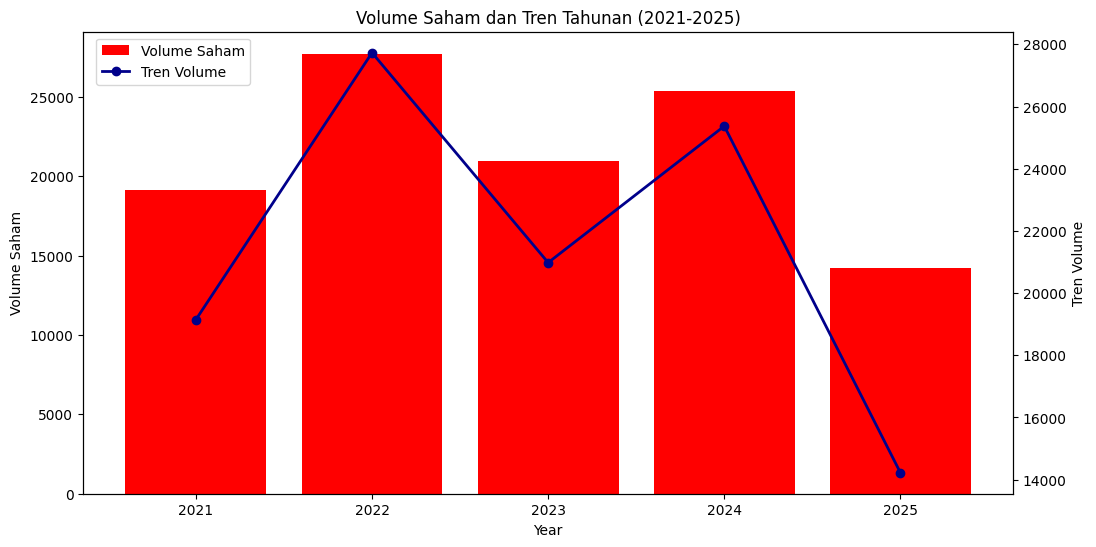

In [19]:
# Ubah kolom 'date' menjadi tipe datetime
data['Date'] = pd.to_datetime(data['Date'])

# Buat kolom 'year' dari kolom 'date'
data['Year'] = data['Date'].dt.year

# Kelompokkan data berdasarkan tahun dan hitung total volume saham per tahun
df_yearly = data.groupby('Year')['Vol.'].sum().reset_index()

# Plot bar chart dan line chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart (volume saham per tahun)
ax1.bar(df_yearly['Year'], df_yearly['Vol.'], color='red', label='Volume Saham')

# Buat axis kedua untuk line chart (volume saham per tahun)
ax2 = ax1.twinx()

# Line chart (tren volume saham per tahun)
ax2.plot(df_yearly['Year'], df_yearly['Vol.'], color='darkblue', label='Tren Volume', marker='o', linestyle='-', linewidth=2)

# Menambahkan label, judul, dan grid
ax1.set_xlabel('Year')
ax1.set_ylabel('Volume Saham', color='black')
ax2.set_ylabel('Tren Volume', color='black')
plt.title('Volume Saham dan Tren Tahunan (2021-2025)')
#ax1.grid(True)

# Tambahkan legend
fig.legend(loc="upper left", bbox_to_anchor=(0.13, 0.88))

# Tampilkan grafik
plt.show()

In [ ]:
Trade = go.Candlestick(x=data['Date'],
                       open=data['Open'],
                       high=data['High'],
                       low=data['Low'],
                       close=data['Close']
                      )

layout = {
    'title': {
            'text' : 'Perkembangan Harga Saham BMRI',
            'x' : 0.5,
            'xanchor' : 'center',
            'yanchor' : 'top'
        },
    'xaxis': {
        'title': 'Waktu',
        'rangeslider': {'visible': False},
        'gridcolor': 'rgba(255, 255, 255, 0.2)',  # Warna garis grid X-axis
    },
    'yaxis': {
        'title': 'Harga Saham (IDR)',
        'gridcolor': 'rgba(255, 255, 255, 0.2)',  # Warna garis grid Y-axis
    },
    'paper_bgcolor': 'black',  # Background di luar plot
    'plot_bgcolor': 'black',  # Background di dalam plot
    'font': {
        'color': 'white'  # Warna teks
    },
    'width' : 1200,
    'height' : 600
}

fig = go.Figure(data=Trade, layout=layout)
fig.show()

## Modelling

In [21]:
model = Prophet()

# Drop columns
model_df = data.drop(['Open', 'High', 'Low', 'Vol.','Change(%)'], axis=1)
model_df.rename(columns={'Close' : 'y', 'Date' : 'ds'}, inplace=True)

model_df

,ds,y,Kode,Year
0,2025-04-16,4.670,BMRI,2025
1,2025-04-15,4.710,BMRI,2025
2,2025-04-14,4.750,BMRI,2025
3,2025-04-11,5.100,BMRI,2025
4,2025-04-10,5.025,BMRI,2025
...,...,...,...,...
1019,2021-01-22,7.200,BMRI,2021
1020,2021-01-21,7.250,BMRI,2021
1021,2021-01-20,7.375,BMRI,2021
1022,2021-01-19,6.975,BMRI,2021


In [22]:
# Inisialisasi dan latih model dengan penyesuaian parameter
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality = 'auto'
)

# Latih model
model.fit(model_df)


22:00:15 - cmdstanpy - INFO - Chain [1] start processing
22:00:18 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Membuat tanggal prediksi
future_prices = model.make_future_dataframe(periods=365)

# prediksi harga
predict = model.predict(future_prices)
predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1384,2026-04-12,2.692454,0.868673,4.568409
1385,2026-04-13,2.691281,0.842530,4.624764
1386,2026-04-14,2.677948,0.825608,4.630514
1387,2026-04-15,2.668502,0.822332,4.633341
1388,2026-04-16,2.689321,0.804530,4.696710


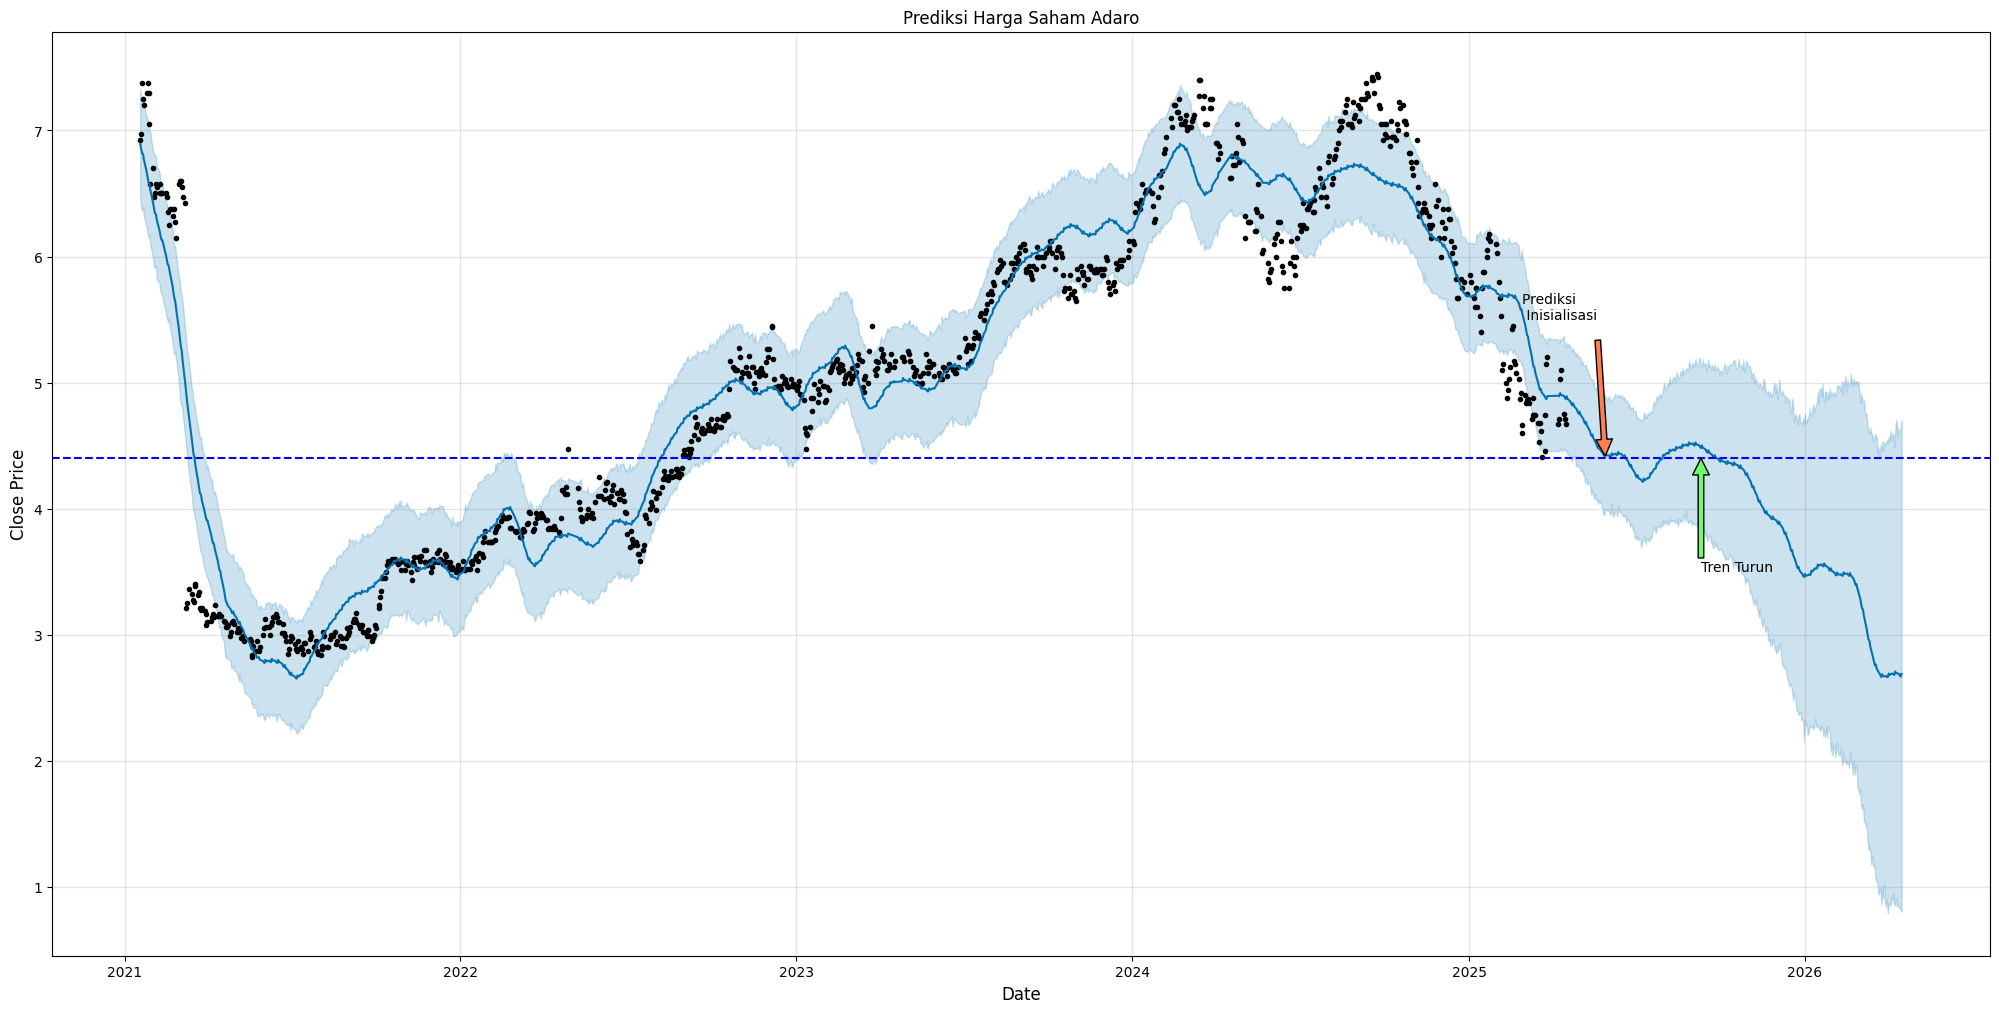

In [24]:
# Dates
start_date = dt.datetime(2025, 2, 27)
start_date1 = mdates.date2num(start_date)

trend_date = dt.datetime(2025, 9, 10)
trend_date1 = mdates.date2num(trend_date)

point_arrow = dt.datetime(2025, 5, 30)
point_arrow1 = mdates.date2num(point_arrow)

# plot
fig, ax1 = plt.subplots(figsize=(25, 12))
model.plot(predict, ax=ax1)
ax1.set_title('Prediksi Harga Saham Adaro')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Close Price', fontsize=12)

# anotasi
ax1.annotate('Prediksi \n Inisialisasi', xy=(point_arrow1, 4.3), xytext=(start_date1, 5.5), 
             arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
             )
ax1.annotate('Tren Turun', xy=(trend_date1, 4.4), xytext=(trend_date1, 3.5), 
             arrowprops=dict(facecolor='#6cff6c', shrink=0.0),
             )

ax1.axhline(y=4.4, color='b', linestyle='--')
plt.show()

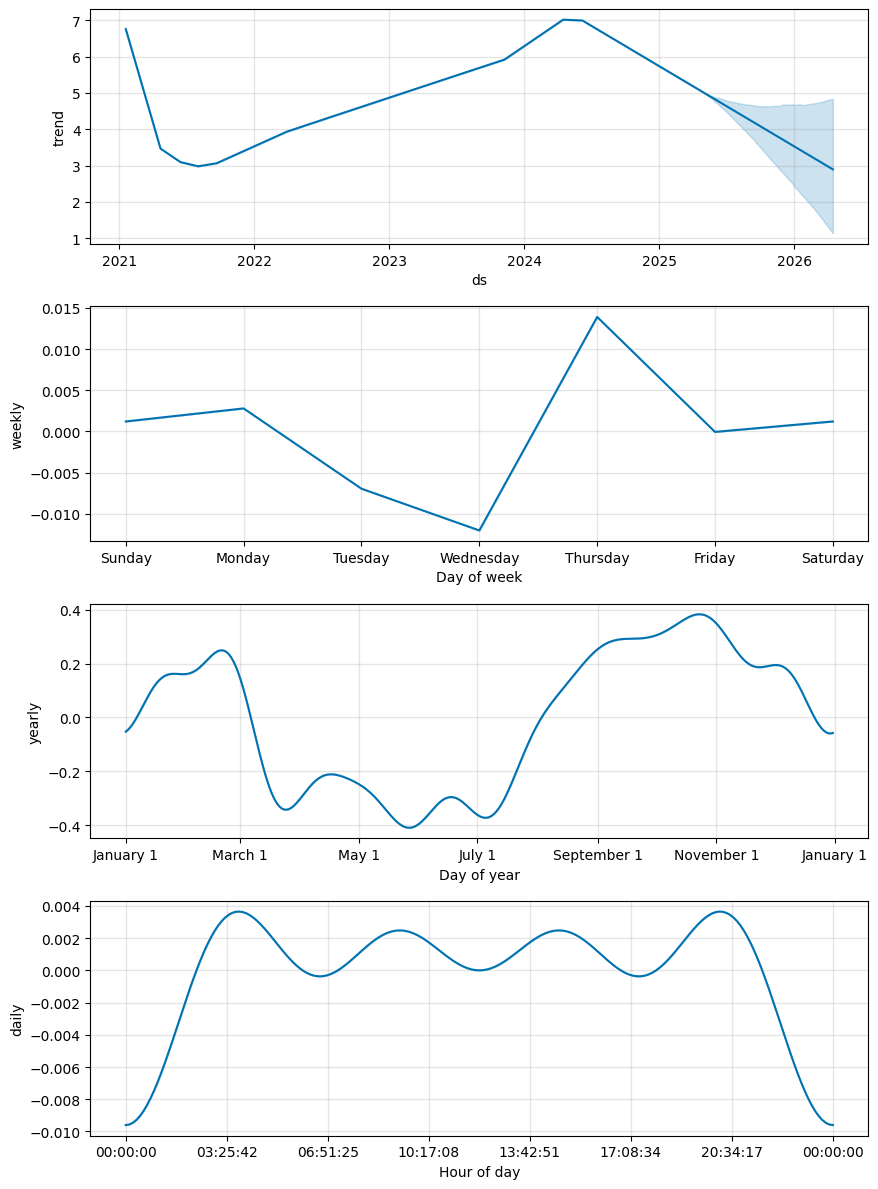

In [25]:
fig2 = model.plot_components(predict)
plt.show()

## Evaluation

In [26]:
cv_data = cross_validation(model, initial='365 days', period='180 days', horizon = '120 days')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/6 [00:00<?, ?it/s]

22:00:24 - cmdstanpy - INFO - Chain [1] start processing
22:00:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.97s/it]22:00:26 - cmdstanpy - INFO - Chain [1] start processing
22:00:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.04s/it]22:00:28 - cmdstanpy - INFO - Chain [1] start processing
22:00:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.74s/it]22:00:30 - cmdstanpy - INFO - Chain [1] start processing
22:00:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.71s/it]22:00:31 - cmdstanpy - INFO - Chain [1] start processing
22:00:33 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.80s/it]22:00:33 - cmdstanpy - INFO - Chain [1] start processing
22:00:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


In [27]:
# Melihat hasil cross validation
cv_data.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
463,2025-04-10,6.550223,6.073728,7.038401,5.025,2024-12-17
464,2025-04-11,6.545801,6.057302,7.093967,5.100,2024-12-17
465,2025-04-14,6.570743,6.098490,7.089442,4.750,2024-12-17
466,2025-04-15,6.566487,6.079931,7.074020,4.710,2024-12-17
467,2025-04-16,6.566261,6.076036,7.123519,4.670,2024-12-17


In [28]:
# Melihat performance metrics
pm_data = performance_metrics(cv_data)
pm_data.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,13 days,0.201293,0.448657,0.374858,0.069353,0.058250,0.067270,0.510870
1,14 days,0.197383,0.444278,0.379298,0.071784,0.061732,0.069640,0.510870
2,15 days,0.182637,0.427360,0.369591,0.070135,0.058250,0.068290,0.500000
3,16 days,0.202341,0.449823,0.396143,0.075098,0.066379,0.073233,0.440217
4,17 days,0.216986,0.465818,0.416417,0.079042,0.073964,0.077230,0.378261


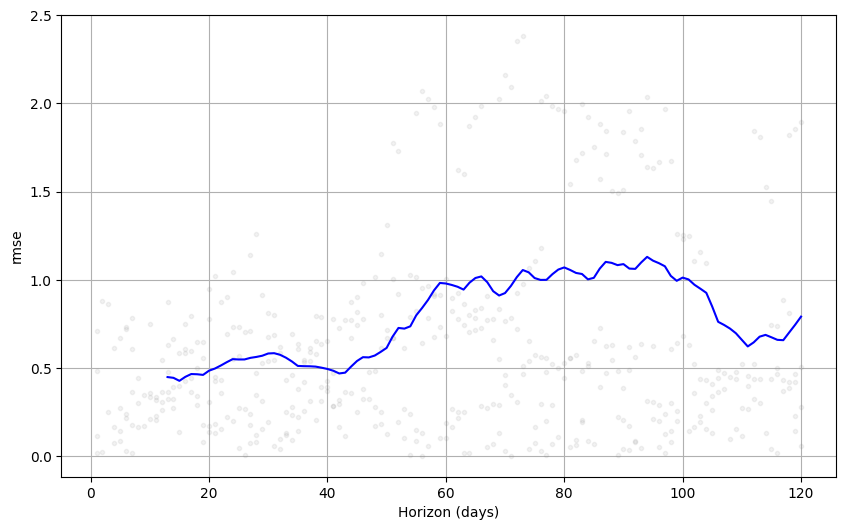

In [29]:
# Visualiasi RMSE
plot_cross_validation_metric(cv_data, metric='rmse')
plt.show()

## Deployment